In [2]:
%matplotlib inline
from PIL import Image
from itertools import repeat
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
import keras.callbacks as cb
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#Hyperparameter
new_width=64
new_height=128
channel=3
epochCount=30
miniBatchSize=256

In [17]:
model_json = model.to_json()
with open("modelR.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelR.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [6]:
train_dir = "./INRIAPerson/train_64x128_H96"
neg="neg.lst"
pos='pos.lst'
neg=os.path.join(train_dir, neg)
pos=os.path.join(train_dir, pos)
print("neg images are stored at:",neg)
print("pos images are stored at:",pos)

neg images are stored at: ./INRIAPerson/train_64x128_H96/neg.lst
pos images are stored at: ./INRIAPerson/train_64x128_H96/pos.lst


In [7]:
#Create two lists that contain locations of positive and negative images
posList=[]
negList=[]
with open(neg, 'r') as f:
    for line in f:
        line=line[6:].strip('\n')
        line=os.path.join(train_dir, line)
        negList.append(line)
with open(pos, 'r') as f:
    for line in f:
        line=line[6:].strip('\n')
        line=os.path.join(train_dir, line)
        posList.append(line)
#Repeat each item in negList 3 times, for image reuse
negList = [x for item in negList for x in repeat(item, 3)]

In [8]:
#Load pos images from path specified at posList
def loadPosImage(lst):
    result=[]
    for entry in lst:
        im=Image.open(entry, 'r')
        width, height = im.size   # Get dimensions
        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2
        im=im.crop((left, top, right, bottom))
        im=np.asarray(im)
        _,_,z=im.shape
        if(z==4):
            im=np.delete(im,3,axis=2)
        #im=im.reshape(new_width*new_height*3)
        result.append(im)
    return result

def loadNegImage(lst):
    result=[]
    for entry in lst:
        im=Image.open(entry, 'r')
        width, height = im.size   # Get dimensions
        width=width-new_width
        height=height-new_height
        #select top left from available range
        top=np.random.randint(0,height)
        left=np.random.randint(0, width)
        im=im.crop((left, top, left+new_width, top+new_height))
        im=np.asarray(im)
        _,_,z=im.shape
        if(z==4):
            im=np.delete(im,3,axis=2)
        #im=im.reshape(new_width*new_height*3)
        result.append(im)
    return result

In [9]:
posImgList=loadPosImage(posList)
negImgList=loadNegImage(negList)

In [10]:
posLength=len(posList)
negLength=len(negList)
print(posLength, " pos images, ", negLength, "neg images")
#create tag for each image
posTag=[[0,1]]*posLength
negTag=[[1,0]]*negLength
dataList=[]
dataList.extend(posImgList)
dataList.extend(negImgList)
dataList=np.array(dataList)
#dataList=np.append(posImgList, negImgList, axis = 0)
dataTag=[]
dataTag.extend(posTag)
dataTag.extend(negTag)
dataTag=np.array(dataTag)

2416  pos images,  3654 neg images


In [11]:
def SGDShuffle(inputList, size,sd):
    np.random.seed(sd)
    np.random.shuffle(inputList);
    length=len(inputList)
    batchNum=int(np.ceil(length/size))
    newList=[]
    for i in range(batchNum-2):
        newList.append(inputList[i*size:(i+1)*size])
    newList.append(inputList[(batchNum-1)*size:])
    return np.array(newList)

In [12]:
sd=np.random.randint(0,1000)
mini_images=SGDShuffle(dataList,miniBatchSize,sd)
mini_labels=SGDShuffle(dataTag,miniBatchSize,sd)
sd=np.random.randint(0,1000)
test_images=SGDShuffle(dataList,miniBatchSize,sd)
test_labels=SGDShuffle(dataTag,miniBatchSize,sd)

In [13]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                activation='relu',
                input_shape=(new_height, new_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


256/256 [==============================] - 0s 852us/step


256/256 [==============================] - 0s 867us/step


256/256 [==============================] - 0s 837us/step


256/256 [==============================] - 0s 887us/step


182/182 [==============================] - 0s 831us/step
[5.054321445641108e-05, 1.0]


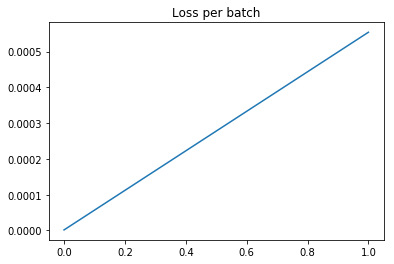

In [16]:
history = LossHistory()
for j in range(epochCount):
    for i in range(len(mini_labels)):
        model.fit(mini_images[i], mini_labels[i], batch_size=len(mini_images[i][0]),
                callbacks=[history],validation_data=(test_images[i], test_labels[i]), verbose=0)
        score = model.evaluate(test_images[i], test_labels[i], batch_size=miniBatchSize
        )
print(score)
plt.plot(history.losses)
plt.title('Loss per batch')
plt.show()